Epoch 1/100
70/70 [==============================] - 8s 44ms/step - loss: 0.4805 - val_loss: 3.2792
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 0.2775 - val_loss: 3.4000
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 0.1859 - val_loss: 2.8848
Epoch 4/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1535 - val_loss: 2.4211
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 0.1344 - val_loss: 2.0745
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 0.1198 - val_loss: 1.8199
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 0.1077 - val_loss: 1.5453
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0910 - val_loss: 1.0369
Epoch 9/100
70/70 [==============================] - 0s 4ms/step - loss: 0.0709 - val_loss: 0.6311
Epoch 10/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0582 - val_loss: 0.3530
Epoch 11

ValueError: x and y must have same first dimension, but have shapes (30,) and (90, 1)

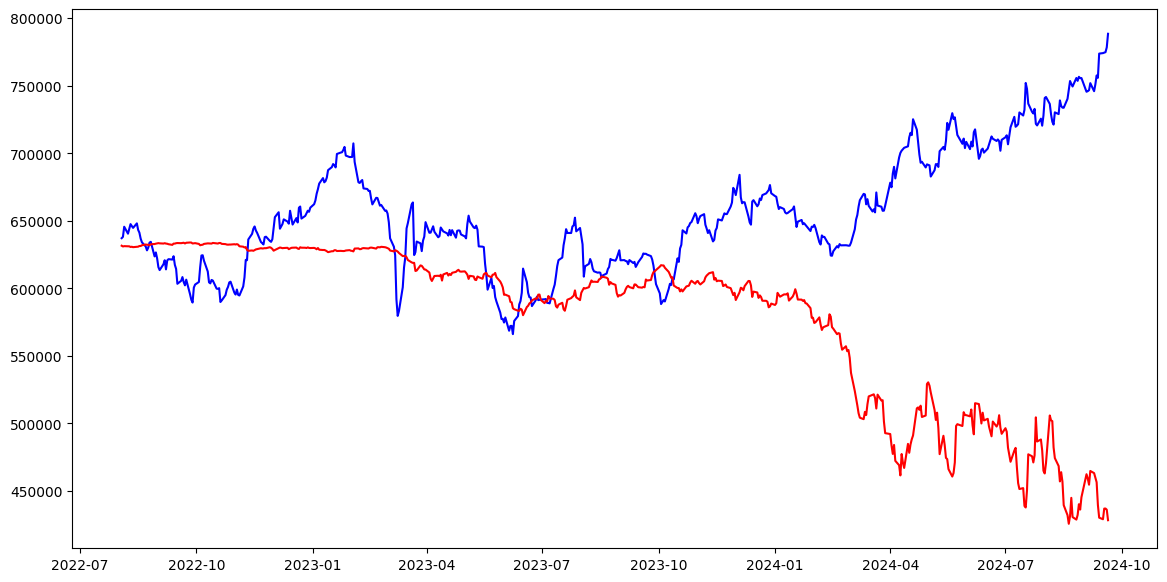

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Apply StandardScaler to both the target and the regressor variables
scaler = StandardScaler()
df[regressors] = scaler.fit_transform(df[regressors])

# Scale the target variable 'y'
target_scaler = StandardScaler()
df['y'] = target_scaler.fit_transform(df[['y']])

# Create lag features for the target variable 'y' with 30 days lag
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Create 30-day lag features for the gold price ('y')
df = create_lag_features(df, lags=30, target_col='y')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)

# Prepare features (X) and target (y) for LSTM
X = df.drop(columns=['ds', 'y'])
y = df['y']

# Apply StandardScaler to the lagged features as well
X_scaled = scaler.fit_transform(X)

# Reshape the data for LSTM input (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(8, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # More units
lstm_model.add(Dropout(0.3))  # Higher dropout to reduce overfitting
lstm_model.add(LSTM(49, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(16, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(8, return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))

# Compile the model with a smaller learning rate
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Predict the gold price on the test set using LSTM
predicted_prices = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values to get them back to the original scale
predicted_prices_rescaled = target_scaler.inverse_transform(predicted_prices)
actual_prices_rescaled = target_scaler.inverse_transform(y_test.values.reshape(-1, 1))

# Calculate the RMSE to evaluate the model's performance
rmse = np.sqrt(mean_squared_error(actual_prices_rescaled, predicted_prices_rescaled))
print(f'Root Mean Squared Error (RMSE) of the LSTM model: {rmse}')

# Forecasting future prices
# Since LSTM was trained on lagged values, we need to simulate future lags for the forecast period
future_dates = pd.date_range(start=df['ds'].max(), periods=30, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Get the last available sequence of features (30 lags)
last_sequence = np.array(X_scaled[-1, :])

# Function to make future predictions using LSTM
def make_future_predictions_lstm(last_sequence, model, num_predictions=90):
    future_predictions = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        # Predict the next value using the LSTM model
        future_pred = model.predict(np.array([current_seq]))
        future_predictions.append(future_pred[0][0])
        
        # Update the sequence with the new predicted value, shift the lags
        current_seq = np.roll(current_seq, -1, axis=0)  # Shift the lag values
        current_seq[-1] = future_pred  # Add the new predicted value

    return future_predictions

# Predict future gold prices for the next 90 days
future_predictions_scaled = make_future_predictions_lstm(last_sequence, lstm_model, num_predictions=90)

# Inverse transform future predictions to original scale
future_predictions = target_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Plot actual, predicted, and future forecasted gold prices on the same plot
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(df['ds'].iloc[train_size:], actual_prices_rescaled, label='Actual Gold Price', color='blue')

# Plot predicted gold prices for the test set
plt.plot(df['ds'].iloc[train_size:], predicted_prices_rescaled, label='LSTM Predictions (Test Set)', color='red')

# Plot future forecasted values (LSTM Model)
plt.plot(future_dates, future_predictions, label='Future Forecasted Gold Price (LSTM)', color='green')

plt.title('Gold Price Forecast (LSTM Model with 30 Days Lag)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the test set predictions and future predictions to CSV
# Create a DataFrame for test set predictions
test_results = pd.DataFrame({
    'date': df['ds'].iloc[train_size:],  # Test set dates
    'actual_gold_lkr': actual_prices_rescaled.flatten(),
    'predicted_gold_lkr': predicted_prices_rescaled.flatten()
})

# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'date': future['ds'],  # Future dates
    'predicted_gold_lkr': future_predictions.flatten()
})

# Combine both DataFrames into one for exporting
combined_results = pd.concat([test_results, future_results], ignore_index=True)

# Save the results to a CSV file
combined_results.to_csv('lstm_30days_lag_forecast_results.csv', index=False)

# Confirm the file has been saved
print("Forecasted and predicted values have been saved to 'lstm_30days_lag_forecast_results.csv'.")
